### Import Dataset

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
from utils.message_preprocess import message_processing
# plot untils funcion
from utils.plot_utils import pie_plot

In [142]:
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

# convert string to list
from ast import literal_eval

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']


,project name,Commit ID,commit_message,Maintenance,Testing,Feature Add,Bug fix,Documentation,Clean up,Build,...,Module Remove,Module Move,Rename,Versioning,Merge,Initialization,Internationalization,Data,Module Add,categories
0,apache-avro,126e9769f45f978f42321c4fc465198982df482b,AVRO-906. Java: Fix so that ordering of schema...,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Bug fix]"
1,apache-avro,2df0775d2f368b326e3ac6442ce4850e3fe62edc,AVRO-2003: Report specific location of schema ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Maintenance]"
2,apache-avro,a39e6deea243dcd9a09df8f67af724003dec1d02,AVRO-1099. Java: Fix JsonDecoder to permit flo...,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Bug fix]"
3,apache-avro,2020c8a8cc19c58eaef2d9de75260e7341099038,AVRO-1046. Java: Fix ReflectDatumReader to be ...,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Testing, Maintenance, Bug fix]"
4,apache-avro,fa0059c55a31813634188eb85e53b68e33644489,AVRO-607: Java: Make SpecificData schema cache...,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[Maintenance, Bug fix]"


### Tags Preprocessing

Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Internationalization : 1
Data : 1
Module Add : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


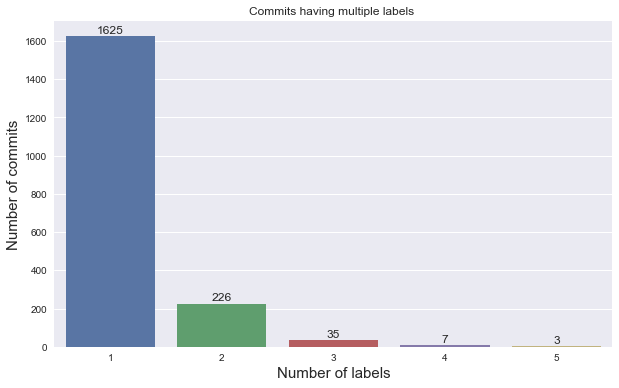

Corrective : 266
Adaptive : 239
Perfective : 1130
Implementation : 334
Non_functional : 70
Other : 34


In [143]:
# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

def group_labels_new(df, labels_to_group, new_label):
    '''
    Group some of labels

    Args:
        df - dataframe
        labels_to_group -  List of labels you want to group
        new_label -  string - new label name of grouped labels

    Returns:
        new_df - dataframe after grouped
    '''
    new_df = df.copy()

    # generate new labels by group labels
    def create_new_label(row, labels):
        new_label = 0  # initialize new label
        for label in labels:
            if row[label] == 1:
                new_label = 1  # if one of labels in grouped labels is 1 the new label is 1
        return new_label

    new_df[new_label] = df.apply(lambda row: create_new_label(row, labels_to_group), axis=1)

    # generate list of new_categories

    return new_df

new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Internationalization', 'Documentation','Data'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Indentation','Maintenance','Module Move','Module Remove','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Initialization', 'Feature Add','Module Add','Internationalization'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

Corrective : 266
Adaptive : 239
Perfective : 1130
Implementation : 334
1    1635
2     148
0     101
3      10
4       2
dtype: int64


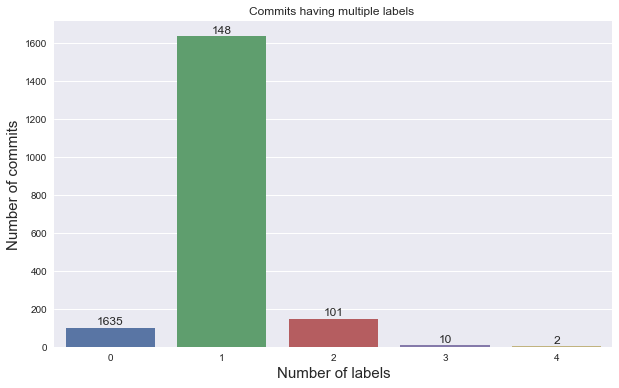

current number of samples: 1896
number of samples after drop:1635


In [144]:
# Drop 'Non-functional' and 'Other'

new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
# new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Perfective','Implementation']
# new_df = new_df[new_df['Implementation']!=1].reset_index(drop=True)
# target_col = ['Adaptive','Perfective','Corrective']
# print('Final shape :', new_df.shape[0])

# form target cols
new_df = new_df.drop('categories', axis = 1)
new_df['target_class'] = np.argmax(new_df[target_col].values, axis = 1)

### Code Change Preprocessing

In [145]:
from Preprocessing_util import Processing 
preprocess = Processing()

In [146]:
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])
print('Number of files:', len(files_path))

folder_path = './sub_1922_labeled_commits/'
all_files, csha = preprocess.parse_json(folder_path, files_path)

print('Number of parsed files:', len(all_files))

_, datas, _ = preprocess.preprocess_roots(all_files)
print('Data shape:', len(datas))
training_data = preprocess.actions2sentence(datas)

apache-avro_126e9769f45f978f42321c4fc465198982df482b.json
Number of files: 1635
Number of parsed files: 1392
Data shape: 1392


In [147]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
new_df_code = pd.merge(commits_df, new_df, on='Commit ID')

print('merged df shape:',new_df_code.shape)

new_df_code['Files'] = new_df_code['Files'].apply(lambda row: ' '.join(row))
print(new_df_code['Files'][11])
print('new merged shape:', new_df_code.shape)

# drop empty code change
new_df_code = new_df_code[new_df_code['Files'].str.strip() != ''].reset_index(drop = True)
print(new_df_code.shape)

(1635, 29)
merged df shape: (1392, 30)
INS_SimpleName_ClassInstanceCreation INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_FieldDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_MethodDeclaration_TypeDeclaration INS_SingleVariableDeclaration_MethodDeclaration INS_ExpressionStatement_Block
new merged shape: (1392, 30)
(1392, 30)


### Pad Sequence and Embedding

In [148]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

10


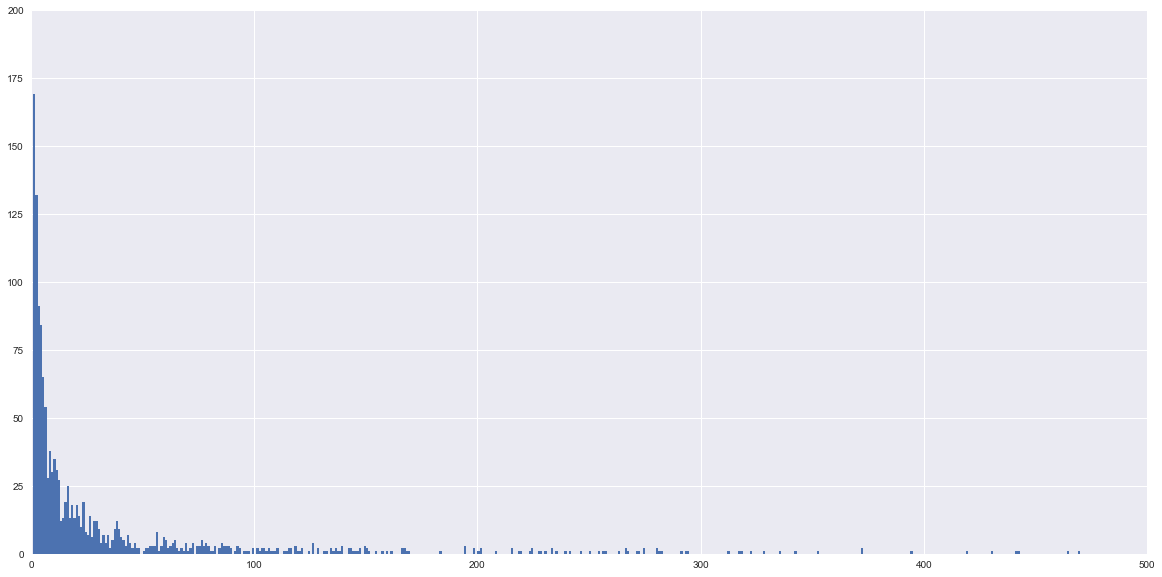

In [149]:
def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)
    plt.xlim((0, 500))
    plt.ylim((0, 200))

number_of_actions = [len(commit.split()) for commit in new_df_code['Files'].values]
plot_hist(number_of_actions)

# getting file threshold
threshold = 0.5

def get_file_threshold(number_of_files, threshold = 0.95):
    '''
    get padding threshold for files dimension
    
    Args:
        number_of_files - array of the number of files in each commits
        threshold - drop all commits with its the number of files beyond this threshold
    Returns:
        padding threshold - number
    '''
    
    total_files = len(number_of_files)
    number_of_files = np.array(number_of_files)
    bincount = np.bincount(number_of_files)

    sum_file = 0
    for index, item in enumerate(bincount):
        sum_file += item
        #print(index,item)
        #print(sum_file)
        if sum_file > threshold*total_files:
            padding_files_threshold = index
            break
            
    return padding_files_threshold

length_threshold = get_file_threshold(number_of_actions, threshold)
print(length_threshold)

In [150]:
# drop too long commits
#new_df_code['len_seq'] = new_df_code.apply(lambda row: len(row['Files'].split()), axis = 1)
#new_df_code_drop = new_df_code[new_df_code['len_seq'] <= length_threshold].reset_index(drop = True)

new_df_code_drop = new_df_code.copy()

#Training 
docs = new_df_code_drop['Files'].values
t = Tokenizer(filters = '', lower=False)
t.fit_on_texts(docs)

sequences = t.texts_to_sequences(docs)
print(sequences[0])

#Pad data 
padded_seq = pad_sequences(sequences, maxlen= length_threshold, padding="post", truncating="post")
print(padded_seq[0])
print(padded_seq.shape)

# vocabulary
vocabulary = t.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

[37, 1, 14]
[37  1 14  0  0  0  0  0  0  0]
(1392, 10)


In [167]:
X = padded_seq
y = new_df_code_drop[target_col].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print('X train shape : ', X_train.shape)
print('X test shape : ', X_test.shape)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state = 42)

# print('X train shape : ', X_train.shape)
# print('X val shape : ', X_val.shape)

X train shape :  (1252, 10)
X test shape :  (140, 10)


### CNN

In [168]:
import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D,GlobalMaxPooling1D, Convolution1D, Embedding, Reshape,Conv2D, MaxPool2D
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from keras.layers.merge import Concatenate
from keras import regularizers
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import set_random_seed
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
import warnings
import os
import random
import numpy as np
import tensorflow as tf
from keras import backend as K
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score, recall_score, classification_report, confusion_matrix

seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
warnings.filterwarnings('ignore')

def print_evaluation_scores(y_test, predicted):
    
    print('Accuracy:', accuracy_score(y_test, predicted))
    print('F1-score macro:', f1_score(y_test, predicted, average='macro'))
    print('F1-score micro:', f1_score(y_test, predicted, average='micro'))
    print('F1-score weighted:', f1_score(y_test, predicted, average='weighted'))

In [170]:
def CNN_model(sequence_length, vocab_size, 
              embedding_dim = 64, 
              filter_sizes = (5,5,5),  
              num_filters = 128,  
              drop_prob = 0.4, 
              hidden_dims = 128, 
              n_class = 4):
    
    # input
    inputs = Input(shape=(sequence_length, ),  dtype='int32')
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length)(inputs)

    # Convolutional block
    conv_blocks = []
    for filter_size in filter_sizes: # Feature > Maintenance > Clean  up > Bug fix > 
        conv = Convolution1D(filters=num_filters,
                         kernel_size=filter_size,
                         padding="same",
                         activation="relu",
                         strides=1,
                         use_bias=True)(embedding)
        
        conv = GlobalMaxPooling1D()(conv) # 1-Max pooling

        conv_blocks.append(conv)

    concatenate = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
    
    dropout = Dropout(drop_prob)(concatenate)
    
    output_layer = Dense(hidden_dims, activation='relu',
                         kernel_regularizer=regularizers.l2(0.1),bias_regularizer=regularizers.l1(0.1)
                        )(dropout)
    

    output = Dense(n_class, activation="softmax")(output_layer)

    model = Model(inputs, output)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss="categorical_crossentropy", optimizer= adam, metrics=["accuracy"])
    
    return model

cnn = CNN_model(100, 500)
cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 100, 64)      32000       input_69[0][0]                   
__________________________________________________________________________________________________
conv1d_164 (Conv1D)             (None, 100, 128)     41088       embedding_69[0][0]               
__________________________________________________________________________________________________
conv1d_165 (Conv1D)             (None, 100, 128)     41088       embedding_69[0][0]               
__________________________________________________________________________________________________
conv1d_166

In [171]:
cnn_model = CNN_model(X_train.shape[1],
                      len(vocabulary_inv.keys()),
                      embedding_dim = 128, 
                      filter_sizes = (5,5,5),  
                      num_filters = 256,  
                      drop_prob = 0.4, 
                      hidden_dims = 128, n_class = 4)

early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.01, patience = 20, verbose = 0, restore_best_weights = True)
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=0, save_best_only=True, mode='auto')

history = cnn_model.fit(X_train, y_train, batch_size=256, epochs=200,
                            validation_data=(X_test, y_test), verbose=2, shuffle = False, callbacks = [early_stop])

y_pred = np.argmax(cnn_model.predict(X_test), axis = 1)
y_test_new = np.argmax(y_test, axis = 1)
print_evaluation_scores(y_test_new, y_pred)

Train on 1252 samples, validate on 140 samples
Epoch 1/200
 - 9s - loss: 22.0858 - acc: 0.5040 - val_loss: 19.8693 - val_acc: 0.6571
Epoch 2/200
 - 2s - loss: 18.5162 - acc: 0.6126 - val_loss: 16.4572 - val_acc: 0.6571
Epoch 3/200
 - 2s - loss: 15.3013 - acc: 0.6150 - val_loss: 13.5253 - val_acc: 0.6571
Epoch 4/200
 - 2s - loss: 12.5268 - acc: 0.6190 - val_loss: 11.0407 - val_acc: 0.6643
Epoch 5/200
 - 2s - loss: 10.1960 - acc: 0.6286 - val_loss: 8.9585 - val_acc: 0.6571
Epoch 6/200
 - 2s - loss: 8.2532 - acc: 0.6398 - val_loss: 7.2510 - val_acc: 0.6500
Epoch 7/200
 - 2s - loss: 6.6585 - acc: 0.6813 - val_loss: 5.8722 - val_acc: 0.6643
Epoch 8/200
 - 2s - loss: 5.3675 - acc: 0.6949 - val_loss: 4.7608 - val_acc: 0.6643
Epoch 9/200
 - 2s - loss: 4.3229 - acc: 0.7037 - val_loss: 3.8670 - val_acc: 0.6714
Epoch 10/200
 - 2s - loss: 3.4875 - acc: 0.7093 - val_loss: 3.1650 - val_acc: 0.6714
Epoch 11/200
 - 2s - loss: 2.8343 - acc: 0.7133 - val_loss: 2.6170 - val_acc: 0.6714
Epoch 12/200
 - 2s

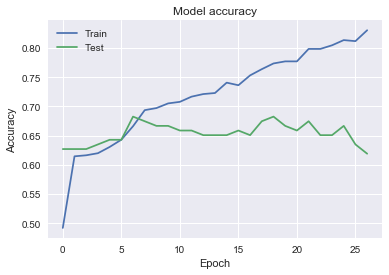

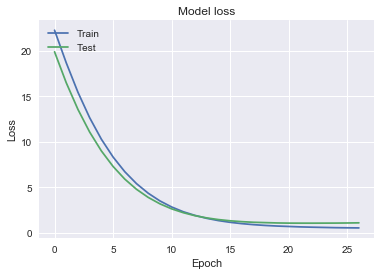

In [161]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("CNN_Genism_64embed_acc.png")
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("CNN_Genism_64embed_loss.png")
plt.show()